In [1]:
from matplotlib import pyplot
import matplotlib
import pandas
from CO2_data_collector import CO2DataCollector
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
import CO2_pre_processing as pre
from pylab import rcParams
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import numpy
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import scipy
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# Collect the data
In this section we show how to collect the emissions data for a given time period

In [42]:
collector = CO2DataCollector()

In [45]:
# Collects the data between two boundaries dates
collector.collect_data('2020-01-01', '2020-05-01')

In [46]:
# Generates a CSV file with the collected data
collector.generate_csv('Emissions_2020_01_01_to_2020-05-01.csv')

# Data Cleaning
In this section we will perform some data cleaning since there are some corrupted data
that needs to be cleaned to convert the Fecha's column from string to a datetime object

In [2]:
dataset = pandas.read_csv('Emissions_2017_01_01_to_2020-05-01.csv')

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175104 entries, 0 to 175103
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  175104 non-null  int64  
 1   Fecha       175104 non-null  object 
 2   Emisiones   175104 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 4.0+ MB


Is there a problem with the data, on certain dates on the interval from 02 to 03, where there are corrupted hours like the following ones:
- 2019-10-27 2A:00
- 2019-10-27 2A:10
- 2019-10-27 2A:20
- 2019-10-27 2A:30
- 2019-10-27 2A:40
- 2019-10-27 2A:50
- 2019-10-27 2B:00
- 2019-10-27 2B:10
- 2019-10-27 2B:20
- 2019-10-27 2B:30
- 2019-10-27 2B:40
- 2019-10-27 2B:50

**Solution:**
- Drop rows which contain the letter 'B' in the Fecha's column
- In the rows where the date contains the characters 2A, replace these with 02

In [4]:
dataset.head()

,Unnamed: 0,Fecha,Emisiones
0,0,2016-12-31 21:00,9659.81
1,1,2016-12-31 21:10,9627.94
2,2,2016-12-31 22:30,9407.57
3,3,2016-12-31 21:20,9562.48
4,4,2016-12-31 21:30,9545.36


In [5]:
# Drop the Unnamed: 0 column
if 'Unnamed: 0' in dataset.columns:
    dataset = dataset.drop(['Unnamed: 0'], axis=1)

In [6]:
# Replace dates with 2A by 02
dataset['Fecha'] = dataset['Fecha'].str.replace('2A', '02')
# Use the NOT simbol (~) to return the dataset without these rows
dataset = dataset[~dataset.Fecha.str.contains("2B")]

In [7]:
dataset.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00,9659.81
1,2016-12-31 21:10,9627.94
2,2016-12-31 22:30,9407.57
3,2016-12-31 21:20,9562.48
4,2016-12-31 21:30,9545.36
5,2016-12-31 21:50,9442.41
6,2016-12-31 22:10,9514.21
7,2016-12-31 21:40,9494.49
8,2016-12-31 22:20,9448.20
9,2016-12-31 22:00,9420.89


As we can see the dataset is unordered, so in order to sort it we must perform the following tasks:
- Convert the Datetime column 'Fecha' to a datetime object
- Set the Datetime column as the Index
- Sort the dataset by index

In [8]:
# Converts 'Fecha' to datetime object
dataset['Fecha'] = pandas.to_datetime(dataset['Fecha'])
# Sets the 'Fecha' column as index
dataset = dataset.set_index('Fecha')
# Sort the dataset by index
dataset = dataset.sort_index()

In [9]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


## Creation of alternative dataset
We will create an alternative dataset where the difference between timestamps is one hour, so the emissions will be grouped by hours

In [10]:
# Cretes the new dataset
dataset_freq_1hour = pre.create_dataset_timefreq_1hour(dataset)

In [11]:
dataset_freq_1hour.head(10)

,Fecha,Emisiones
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97
5,2017-01-01 02:00:00,53940.48
6,2017-01-01 03:00:00,51843.22
7,2017-01-01 04:00:00,50390.88
8,2017-01-01 05:00:00,49331.71
9,2017-01-01 06:00:00,48633.39


## CSV Creation
Now we will create two csv files to store the cleaned dataset. In the first dataset, the difference between timestamps is one hour, while in the second the difference is ten minutes

In [12]:
dataset.head()

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49


In [13]:
dataset_freq_1hour.head()

,Fecha,Emisiones
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97


**Creates 1 hour difference CSV**

In [14]:
# Creates a new CSV with no data errors and ordered rows by date
dataset_freq_1hour.to_csv("2017_01_01_to_2020-05-01_Emissions_by_hour_Clean.csv", index=False)

**Creates 10 minutes difference CSV**

In [20]:
# Creates a new CSV with no data errors and ordered rows by date
dataset.to_csv("2017_01_01_to_2020-05-01_Emissions_by_10_minutes_Clean.csv")

# Data Analysis

In [149]:
# Read both csv files
dataset_by_10_minutes = pandas.read_csv('2017_01_01_to_2020-05-01_Emissions_by_10_minutes_Clean.csv')
dataset_by_hour = pandas.read_csv('2017_01_01_to_2020-05-01_Emissions_by_hour_Clean.csv')

CSV files cannot cannot save datetime objects and saves the rows unordered, so each time we read a CSV file, we must
to perform the following tasks:
- Convert 'Fecha' column to datetime object
- Set 'Fecha' column as the new index
- Sort the dataset by DateTime Index

In [150]:
# This function perform the tasks above
dataset_by_10_minutes = pre.prepare_timeseries_dataset(dataset_by_10_minutes, 0)
dataset_by_hour = pre.prepare_timeseries_dataset(dataset_by_hour, 0)

In [151]:
dataset_by_10_minutes.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,9659.81
2016-12-31 21:10:00,9627.94
2016-12-31 21:20:00,9562.48
2016-12-31 21:30:00,9545.36
2016-12-31 21:40:00,9494.49
2016-12-31 21:50:00,9442.41
2016-12-31 22:00:00,9420.89
2016-12-31 22:10:00,9514.21
2016-12-31 22:20:00,9448.20


In [152]:
dataset_by_hour.head(10)

,Emisiones
Fecha,
2016-12-31 21:00:00,57332.49
2016-12-31 22:00:00,56671.33
2016-12-31 23:00:00,57666.70
2017-01-01 00:00:00,57684.04
2017-01-01 01:00:00,56670.97
2017-01-01 02:00:00,53940.48
2017-01-01 03:00:00,51843.22
2017-01-01 04:00:00,50390.88
2017-01-01 05:00:00,49331.71


## Resample the dataset
In this section we will try to resample the dataset in order to obtain the mean of emissions for each month and decompose it to analyze
the trend and seasonality

In [153]:
dataset_by_hour.index

DatetimeIndex(['2016-12-31 21:00:00', '2016-12-31 22:00:00',
               '2016-12-31 23:00:00', '2017-01-01 00:00:00',
               '2017-01-01 01:00:00', '2017-01-01 02:00:00',
               '2017-01-01 03:00:00', '2017-01-01 04:00:00',
               '2017-01-01 05:00:00', '2017-01-01 06:00:00',
               ...
               '2020-04-30 11:00:00', '2020-04-30 12:00:00',
               '2020-04-30 13:00:00', '2020-04-30 14:00:00',
               '2020-04-30 15:00:00', '2020-04-30 16:00:00',
               '2020-04-30 17:00:00', '2020-04-30 18:00:00',
               '2020-04-30 19:00:00', '2020-04-30 20:00:00'],
              dtype='datetime64[ns]', name='Fecha', length=29179, freq=None)

If we look the frequency of our dataset, it is set to None, so we will have to infer it in order to resample the dataset

In [154]:
# Converts the dataset into a frequency of 1 hour, it doesn't change the data because it already have a frequency of 1 hour
dataset_by_hour = dataset_by_hour.asfreq('H')

### Check and handle missing values

In [155]:
dataset_by_hour.isnull().sum()

Emisiones    5
dtype: int64

Due to setting the frequency, 4 missing values have been created so we will use interpolation to handle them

In [156]:
dataset_by_hour = dataset_by_hour.interpolate()

Now we will try to resample the dataset to a monthly frequency and the mean of emissions

In [157]:
dataset_by_hour.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29184 entries, 2016-12-31 21:00:00 to 2020-04-30 20:00:00
Freq: H
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Emisiones  29184 non-null  float64
dtypes: float64(1)
memory usage: 456.0 KB


In [158]:
series_by_month = dataset_by_hour['Emisiones'].resample('MS').mean()

In [160]:
dataset_by_month = pandas.DataFrame({'Emisiones':series_by_month.values}, index=series_by_month.index)

In [161]:
dataset_by_month.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 41 entries, 2016-12-01 to 2020-04-01
Freq: MS
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Emisiones  41 non-null     float64
dtypes: float64(1)
memory usage: 656.0 bytes


In [163]:
dataset_by_month.head(10)

,Emisiones
Fecha,
2016-12-01,57223.506667
2017-01-01,61563.669220
2017-02-01,46414.701845
2017-03-01,29025.676862
2017-04-01,24765.413931
2017-05-01,38081.439140
2017-06-01,50720.670472
2017-07-01,49045.904637
2017-08-01,39786.220941


In [164]:
# Check if some missing values have been created because of resampling
dataset_by_month.isnull().sum()

Emisiones    0
dtype: int64

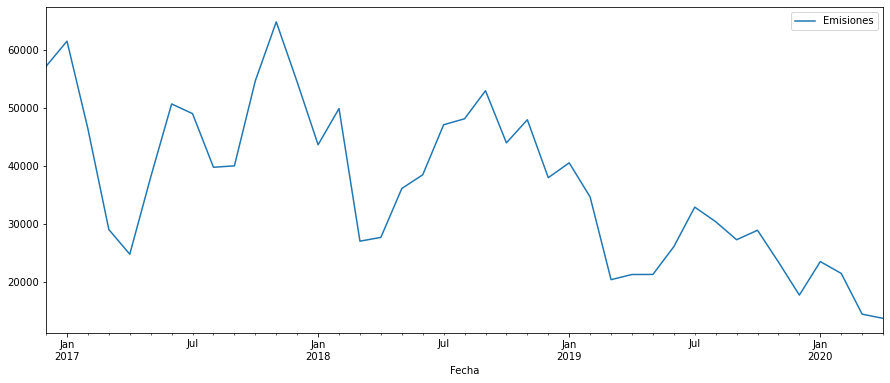

In [165]:
dataset_by_month.plot(figsize=(15, 6))
pyplot.show()

Looking the data we can form some hypotheses:
- It has a decreasing trend, maybe caused by some energy related politics which improve the use of renovables energies through the years
- It shows a seasonality pattern, from January to April emissions decrease greatly, then from April to December they increases to the peak but with some decreasing in September or October.

## Decompose the series

Now we will decompose the series into an additive or multiplicative series.

**Additive Series:**
Value = Base Level + Trend + Seasonality + Error

**Multiplicative Series:**
Value = Base Level * Trend * Seasonality * Error

It seems that the dataset is a multiplicative series because of it seems to be non-linear, the seasonality has different frequency and amplitude over time, we will plot both models and confirm this hypotheses

In [206]:
## If our dataset would not have a specific frequency, we would have to add the period parameter.
# Multiplicative Decomposition
result_mul = seasonal_decompose(dataset_box_transformation, model='multiplicative')
# Additive Decomposition
result_add = seasonal_decompose(dataset_box_transformation, model='additive')

In [207]:
# Set the figsize
rcParams['figure.figsize'] = 11, 11

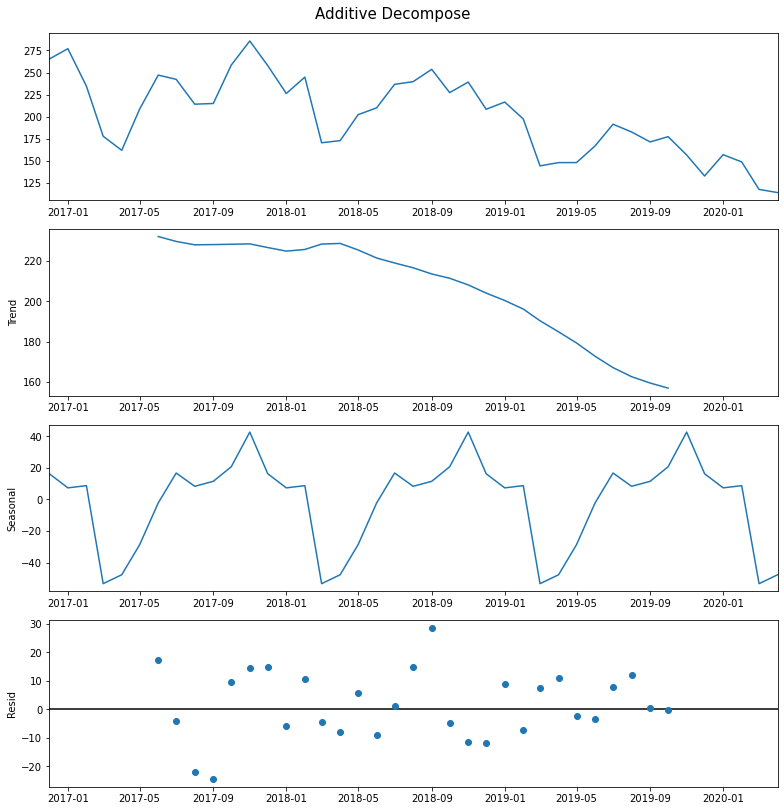

In [208]:
# Plot additive decomposition
result_add.plot().suptitle('Additive Decompose', fontsize=15, y=1.02)
pyplot.show()

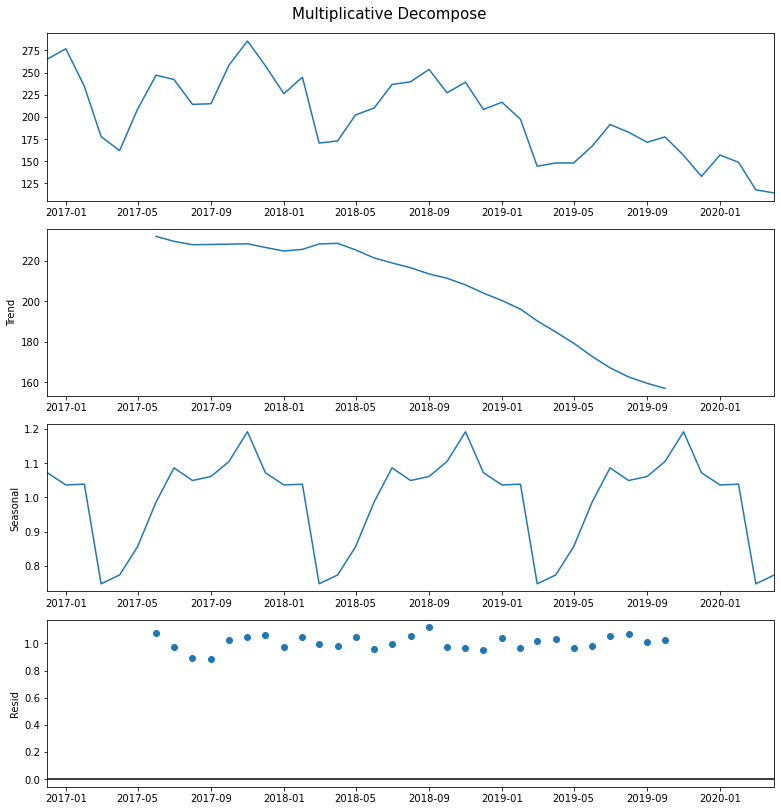

In [209]:
# Plot multiplicative decomposition
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=15, y=1.02)
pyplot.show()

## Stationary Test (Dickey-Fuller Test)
The Dickey-Fuller Test is a type of unit root test. The intuition vehind is that it determines how strongly a time series is defined by a trend.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

   **Null Hypothesis (H0):** If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.

   **Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.
   
The output is an ADF value and a p-value. The ADF number should be a negative number and the p-value should be beneath a certain threshold value (e.g., 1% or 5%, etc) for a confidence level. For this example, we’ll use 5% (or 95% confidence level), so:

If the **p-value > 0.05**: Fail to reject the null hypothesis because the data has a unit root and is non-stationary.

If the **p-value <= 0.05**: Reject the null hypothesis because the data does not have a unit root and is stationary. 

Also, we have to compare the ADF value with the critical values for 99%, 90% and 95% confidence levels

In [191]:
# Apply the test on series values
test_result = adfuller(dataset_sqrt_transformation, autolag='AIC')

# Output the results
print('ADF Statistic: %f' % test_result[0])
print(f'p-value: {test_result[1]}')
print('Critical Values:')
for key, value in test_result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.824925
p-value: 0.36815896964992123
Critical Values:
	1%: -3.606
	5%: -2.937
	10%: -2.607


It is strange because the plots shows that the data is non-stationary but this outputs shows the contray:
- A small p-value, smaller than 0.05 so the Null Hypothesis is rejected
- The test value -8.96 is smaller than the 1% confidence value -3.431

### Transformations

Now we will apply some transformations to the data in order to apply the test again and see if it is stationary

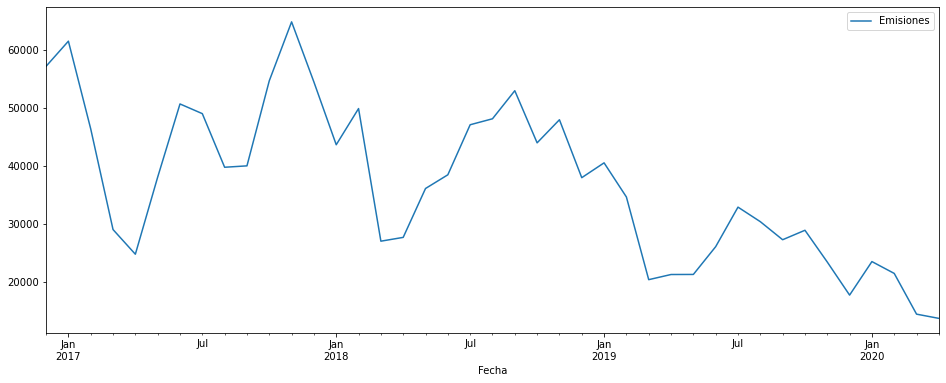

In [171]:
pyplot.rcParams['figure.figsize']=(16, 6)
# line plot
dataset_by_month.plot()

It shows a decreasing trend so it is non-stationary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207C307EC88>]],
      dtype=object)

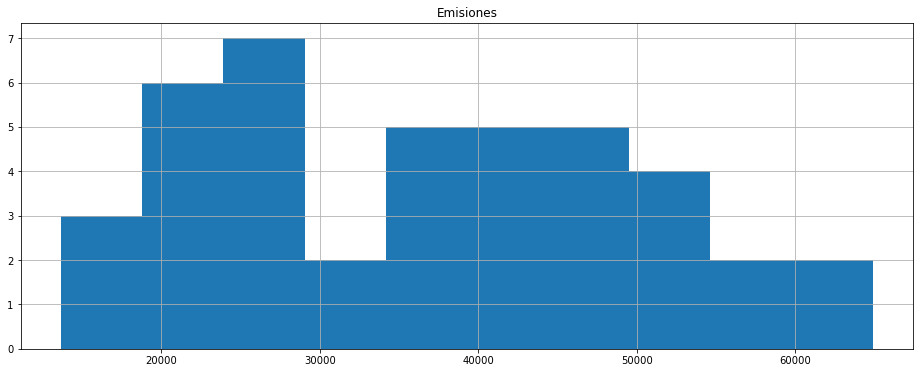

In [172]:
dataset_by_month.hist()

Looking the histogram, it doesn't have a normal distribution so it is clearly non-stationary 

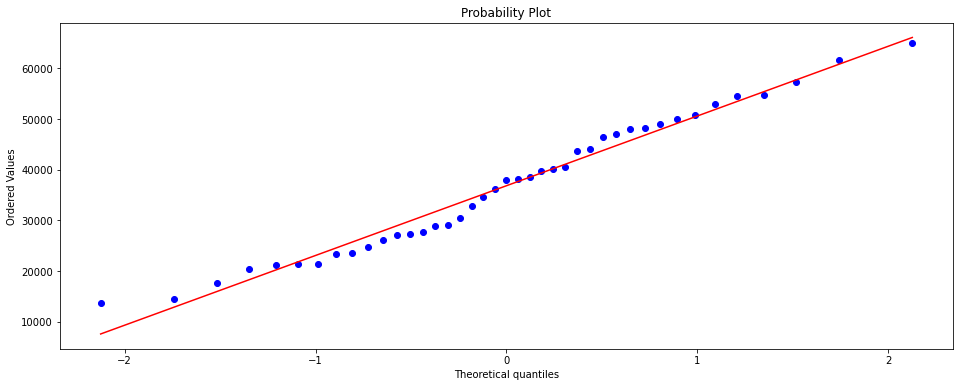

In [174]:
scipy.stats.probplot(dataset_by_month['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()

#### Square Root Transform

In [175]:
dataset_sqrt_transformation = dataset_by_month
dataset_sqrt_transformation['Emisiones'] = numpy.sqrt(dataset_sqrt_transformation['Emisiones'])

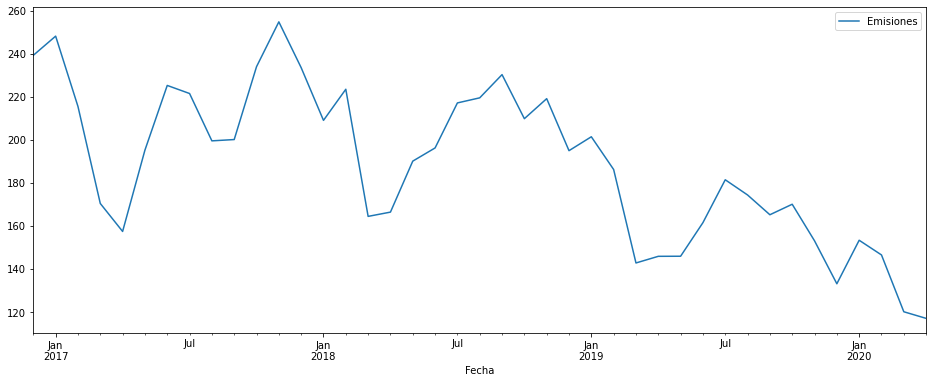

In [176]:
# line plot
dataset_sqrt_transformation.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207C3CDA188>]],
      dtype=object)

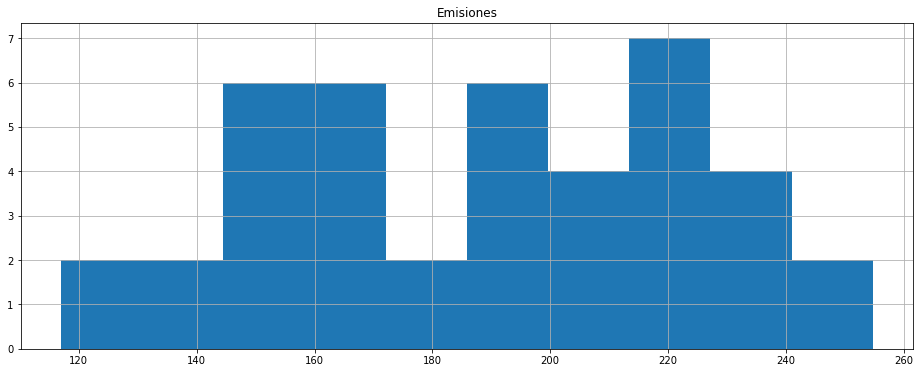

In [177]:
dataset_sqrt_transformation.hist()

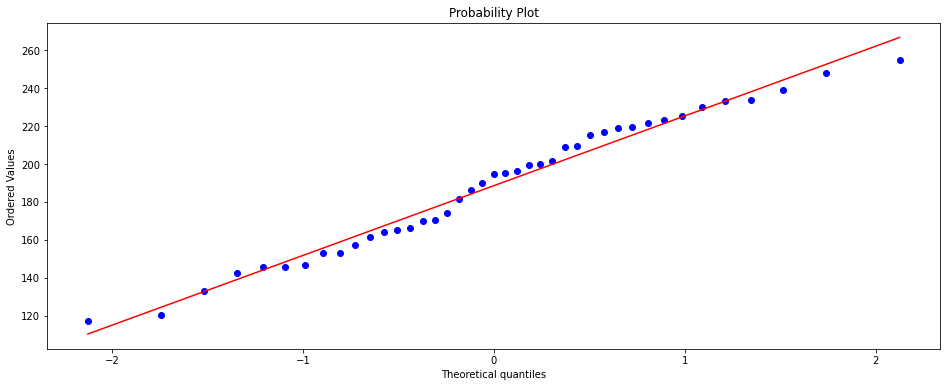

In [178]:
scipy.stats.probplot(dataset_sqrt_transformation['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()

#### Logarithm Transform

In [180]:
dataset_log_transformation = dataset_by_month
dataset_log_transformation['Emisiones'] = numpy.sqrt(dataset_log_transformation['Emisiones'])

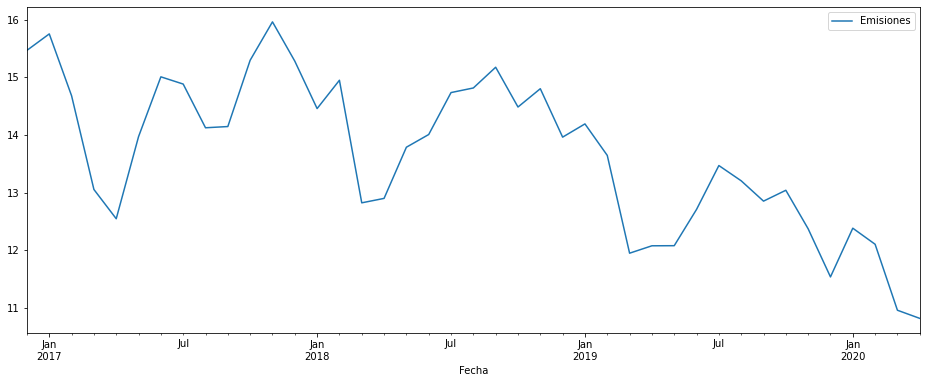

In [181]:
# line plot
dataset_log_transformation.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207C3C6E608>]],
      dtype=object)

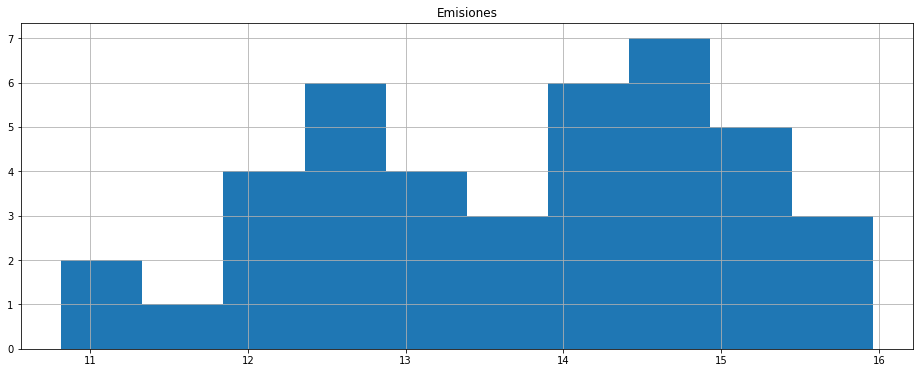

In [182]:
# hist plot
dataset_log_transformation.hist()

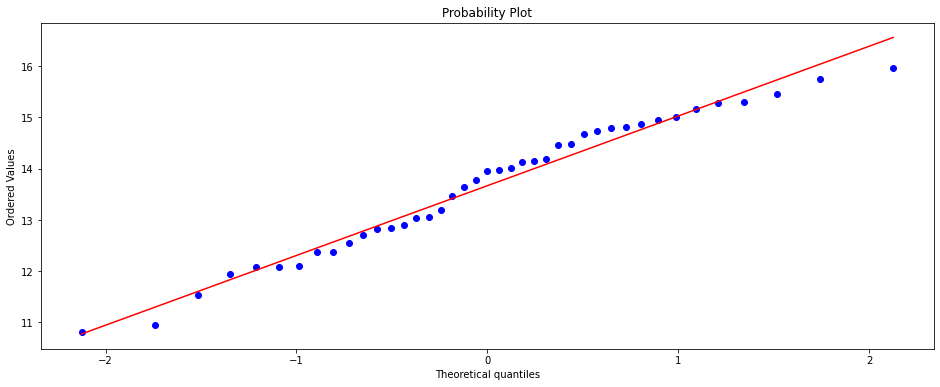

In [183]:
scipy.stats.probplot(dataset_log_transformation['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()

#### Box-Cox Transform

In [184]:
dataset_box_transformation = dataset_by_month
#dataset_box_transformation.columns = ['Emisiones']
dataset_box_transformation['Emisiones'], lam = boxcox(dataset_box_transformation['Emisiones'])

In [50]:
#dataset_box_transformation = pandas.DataFrame(dataset_by_hour.Emisiones)
#dataset_box_transformation.columns = ['Emisiones']
#dataset_box_transformation['Emisiones'], lam = boxcox(dataset_box_transformation['Emisiones'])

In [185]:
lam

2.350457483306345

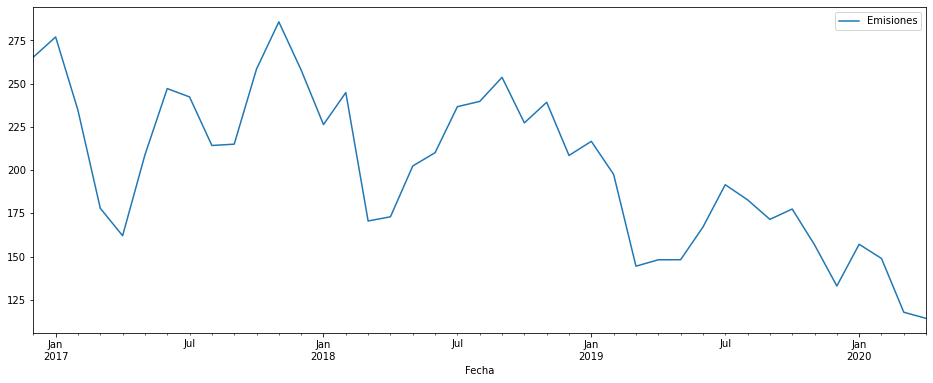

In [186]:
dataset_box_transformation.plot()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000207C49133C8>]],
      dtype=object)

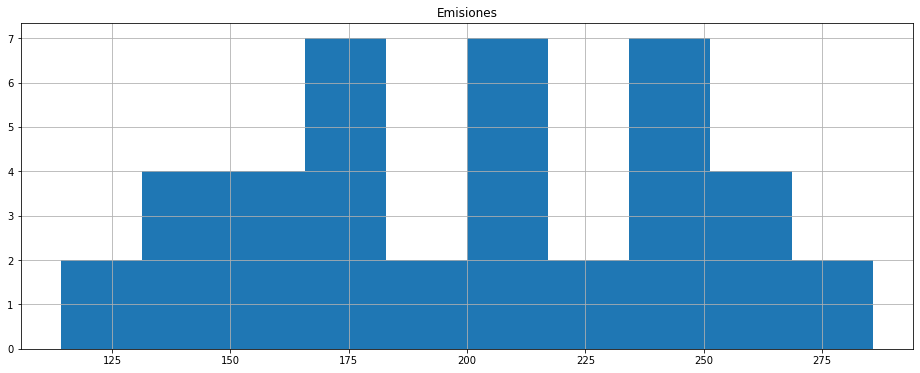

In [187]:
dataset_box_transformation.hist()

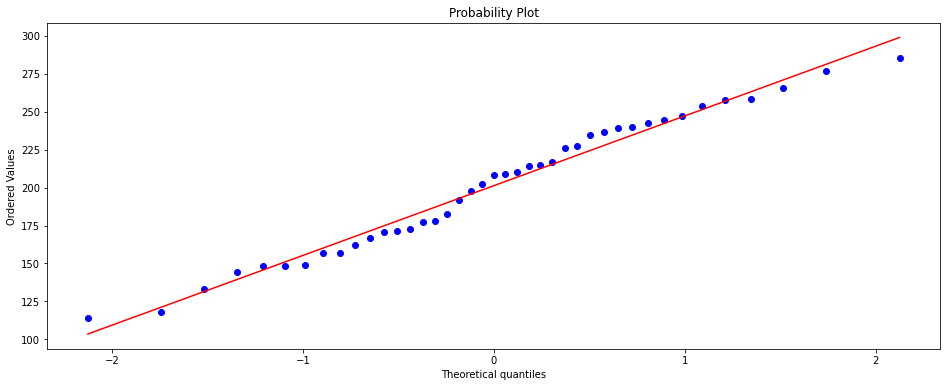

lambda parameter for Box-Cox Transformation is: 2.350457483306345


In [188]:
scipy.stats.probplot(dataset_box_transformation['Emisiones'], dist='norm', plot=pyplot)
pyplot.show()
print ("lambda parameter for Box-Cox Transformation is:", lam)

# Prophet model
In this section we will apply different prophet models to two different dataset: The first is non-stationary and the second one is stationary

## Create the datasets
In order to apply Prophet to a dataset, it must have two specific columns names:
- 'ds' which are the timestamps
- 'y' which are the values
So we must rename 'Fecha' to 'ds' and 'Emisiones' to 'y'

**Creation of the non-stationary dataset**

In [210]:
# Create the dataset
prophet_dataset = dataset_by_hour

# Reset the index in order to be able to rename te columns
prophet_dataset = prophet_dataset.reset_index()
prophet_dataset = prophet_dataset.rename(columns={"Fecha": "ds", "Emisiones": "y"})

prophet_dataset.head()

,ds,y
0,2016-12-31 21:00:00,57332.49
1,2016-12-31 22:00:00,56671.33
2,2016-12-31 23:00:00,57666.70
3,2017-01-01 00:00:00,57684.04
4,2017-01-01 01:00:00,56670.97


**Creation of the stationary dataset**

To create it we must apply a logarithm transformation to the 'Emisiones' column, which is renamed as y

In [211]:
# Create the dataset
prophet_dataset_log = prophet_dataset
# Apply log transformation to have a normal distribution
prophet_dataset_log['y'] = numpy.sqrt(prophet_dataset_log['y'])

prophet_dataset_log.head()

,ds,y
0,2016-12-31 21:00:00,239.442039
1,2016-12-31 22:00:00,238.057409
2,2016-12-31 23:00:00,240.138918
3,2017-01-01 00:00:00,240.175020
4,2017-01-01 01:00:00,238.056653


## Fit the models
We must create two kinds of models:
- A model which fit additive timeseries
- A model which fit multiplicative timeseries

In [212]:
# Create the additive model
prophet_additive = Prophet()
# Create the multiplicative model
prophet_multiplicative = Prophet(seasonality_mode='multiplicative')

We will fit the additive model with the stationary data and the multiplicative model with the non-stationary data

In [213]:
# Fit both models
prophet_additive.fit(prophet_dataset_log)
prophet_multiplicative.fit(prophet_dataset)

Now we create the dates for which to make predictions

In [214]:
future_dates = prophet_additive.make_future_dataframe(periods=24, freq='H')
future_dates.tail()

,ds
29203,2020-05-01 16:00:00
29204,2020-05-01 17:00:00
29205,2020-05-01 18:00:00
29206,2020-05-01 19:00:00
29207,2020-05-01 20:00:00


## Forecast future dates

In [215]:
forecast_additive = prophet_additive.predict(future_dates)
forecast_additive[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
29203,2020-05-01 16:00:00,124.132465,99.300198,150.170298
29204,2020-05-01 17:00:00,123.456777,97.424312,149.126822
29205,2020-05-01 18:00:00,124.750266,96.824879,150.197317
29206,2020-05-01 19:00:00,127.743460,100.488967,155.407594
29207,2020-05-01 20:00:00,130.503891,104.194523,155.859963


In [216]:
forecast_multiplicative = prophet_multiplicative.predict(future_dates)
forecast_multiplicative[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
29203,2020-05-01 16:00:00,117.687394,93.018849,143.897713
29204,2020-05-01 17:00:00,117.271959,90.421303,143.204604
29205,2020-05-01 18:00:00,118.149039,93.766649,144.529680
29206,2020-05-01 19:00:00,120.120625,93.238699,146.399179
29207,2020-05-01 20:00:00,121.903353,96.079277,147.368009


**Plot the additive forecasts**

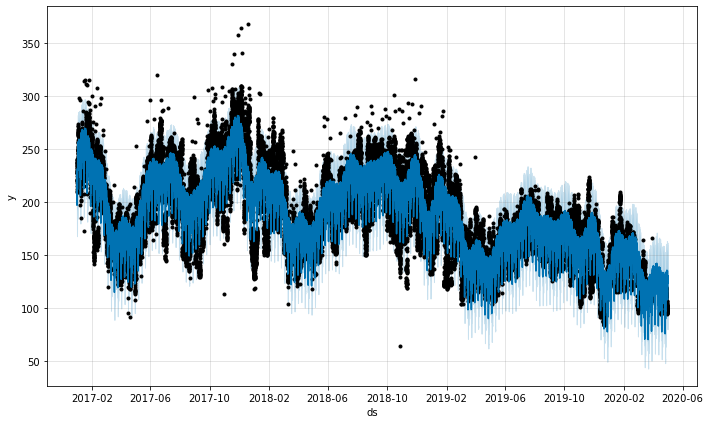

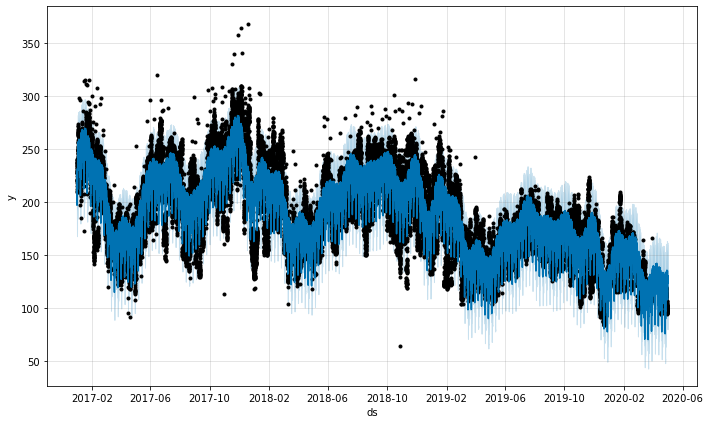

In [217]:
prophet_additive.plot(forecast_additive, uncertainty=True)

**Plot the multiplicative forecasts**

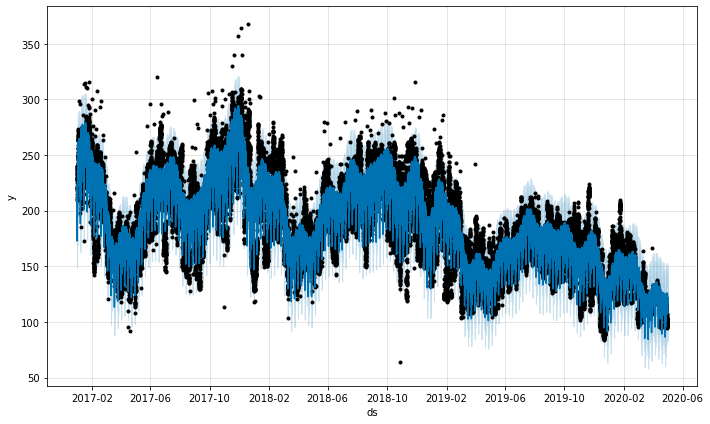

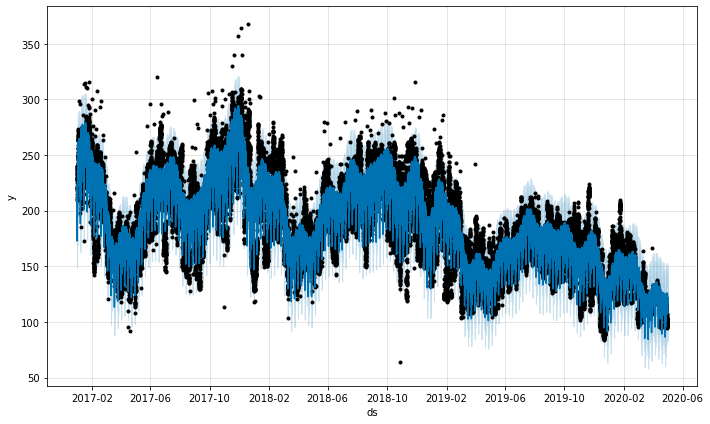

In [218]:
prophet_multiplicative.plot(forecast_multiplicative, uncertainty=True)

## Cross Validation and Perfomance Metrics
We will apply cross validation method and evaluate the perfomance metrics

**CAUTION: This process takes long running**

**Parameters:**
- **initial:** How many days use for train the data, in this case we will use the first 2 years (730 days)
- **period:** Once trained, how often do a prediction, in this case each 90 days
- **horizon:** How much time forecast, in this case 24 hours

In [ ]:
df_cv_additive = cross_validation(prophet_additive, initial='1095 days', period='24 days', horizon = '24 hours')
df_cv_additive.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2020-01-24 20:00:00 and 2020-04-29 20:00:00


In [ ]:
df_cv_multiplicative = cross_validation(prophet_multiplicative, initial='1095 days', period='24 days', horizon = '24 hours')
df_cv_multiplicative.head()

## Compare metrics
In order to compare the metrics we will apply exponential transformation to the additive results so both metrics are in the same scale

In [21]:
# Undo the log transformation to compare metrics in the same scale
df_cv_additive[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = numpy.exp(df_cv_additive[['yhat', 'yhat_lower', 'yhat_upper', 'y']])

additive_metrics = performance_metrics(df_cv_additive)
additive_metrics.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,03:00:00,3.391672e+07,5823.806276,5145.675081,0.179447,0.176829,0.800000
1,04:00:00,3.377768e+07,5811.856879,5381.639686,0.214378,0.222389,0.716667
2,05:00:00,3.088350e+07,5557.292119,5188.515752,0.229799,0.201340,0.633333
3,06:00:00,2.607848e+07,5106.709461,4768.559756,0.226774,0.217364,0.600000
4,07:00:00,2.204411e+07,4695.115454,4438.941556,0.217333,0.204097,0.600000


In [22]:
df_cv_multiplicative[['yhat', 'yhat_lower', 'yhat_upper', 'y']] = numpy.exp(df_cv_multiplicative[['yhat', 'yhat_lower', 'yhat_upper', 'y']])

multiplicative_metrics = performance_metrics(df_cv_multiplicative)
multiplicative_metrics.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,03:00:00,3.022956e+07,5498.141656,5099.636238,0.176815,0.162765,0.800000
1,04:00:00,3.232335e+07,5685.362409,5431.812504,0.214774,0.214087,0.716667
2,05:00:00,3.124056e+07,5589.325241,5331.846023,0.233593,0.192431,0.633333
3,06:00:00,2.750407e+07,5244.432671,4982.780352,0.233395,0.222543,0.600000
4,07:00:00,2.393541e+07,4892.382864,4697.751948,0.225793,0.212138,0.600000


In [23]:
df_cv_multiplicative.tail(50)

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
70,2019-07-04 19:00:00,32770.610460,24965.332538,43263.907908,43983.50,2019-07-03 20:00:00
71,2019-07-04 20:00:00,33999.255854,26224.399303,45004.238887,44594.50,2019-07-03 20:00:00
72,2019-10-01 21:00:00,33673.348906,25887.035699,44143.904858,30443.06,2019-10-01 20:00:00
73,2019-10-01 22:00:00,32726.688091,25009.753960,42621.884048,26852.68,2019-10-01 20:00:00
74,2019-10-01 23:00:00,30831.916758,23750.344891,39716.940586,24039.46,2019-10-01 20:00:00
75,2019-10-02 00:00:00,28736.341609,21950.348828,37463.970540,23010.24,2019-10-01 20:00:00
76,2019-10-02 01:00:00,27048.134754,20997.158559,35813.644697,22111.70,2019-10-01 20:00:00
77,2019-10-02 02:00:00,25987.630737,20136.647963,34127.810596,21269.32,2019-10-01 20:00:00
78,2019-10-02 03:00:00,25522.730150,19695.904932,33499.313753,21225.78,2019-10-01 20:00:00
79,2019-10-02 04:00:00,25600.877288,19539.175242,33379.067820,21283.04,2019-10-01 20:00:00


Looking both perfomance metrics, they are very similar but Prophet with the multiplicative option seems to perform better on large values

# ARIMA Model
In this section we will implement an ARIMA model to see if it performs better than Prophet

In [155]:
import itertools
import statsmodels.api as sm
pyplot.style.use('fivethirtyeight')

In [168]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

print('Examples of parameter combinations for Seasonal ARIMA...')
print('ARIMA: {} '.format(pdq[1]))
print('ARIMA: {} '.format(pdq[1]))
print('ARIMA: {} '.format(pdq[2]))
print('ARIMA: {} '.format(pdq[2]))

Examples of parameter combinations for Seasonal ARIMA...
ARIMA: (0, 0, 1) 
ARIMA: (0, 0, 1) 
ARIMA: (0, 1, 0) 
ARIMA: (0, 1, 0) 


## Grid Search
We will use Grid Search to find the best (p, d, q) values for the series. The model will return the AIC measures, in this case we are interested in the parameters which output the lowest AIC

**IMPORTANT: This takes 3 hours to output all the combinations**

In [169]:
arima_dataset = dataset_sqrt_transformation

for param in pdq:
        try:
            mod = mod = ARIMA(arima_dataset, order=param)

            results = mod.fit()

            print('ARIMA{} - AIC:{}'.format(param, results.aic))
        except:
            continue

ARIMA(0, 0, 0) - AIC:95873.24162886228
ARIMA(0, 0, 1) - AIC:67380.13520147183
ARIMA(0, 1, 0) - AIC:11564.924671470972
ARIMA(0, 1, 1) - AIC:11391.221972682237
ARIMA(1, 0, 0) - AIC:11304.118041827118
ARIMA(1, 0, 1) - AIC:11167.802251686451
ARIMA(1, 1, 0) - AIC:11355.482704095491
ARIMA(1, 1, 1) - AIC:10962.675215801442


Looking the outputs, the parameter combination which outputs a lower AIC values are the following:

(p, d, q)(P, D, Q)s = (0, 1, 1) (1, 1, 1, 12)12

## Fitting model
Now we will fit the model with the best parameter combination above

In [170]:
# Creates the model with custom parameters
mod = ARIMA(arima_dataset, order=(1,1,1))

# Train the model with the data
results = mod.fit()

# Output some information
print(results.summary().tables[1])

                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0002      0.000     -0.430      0.667      -0.001       0.001
ar.L1.D.Emisiones     0.9288      0.005    192.904      0.000       0.919       0.938
ma.L1.D.Emisiones    -0.9854      0.003   -376.350      0.000      -0.991      -0.980


From the table above, the 'coef' column show the weight importance of each term an how each one impacts the time series. The The P>|z| column informs us of the significance of each feature weight. 

Here, each weight has a p-value of 0 and none of the term's coefficients is really close to 0, so it is reasonable to retain them in our model.

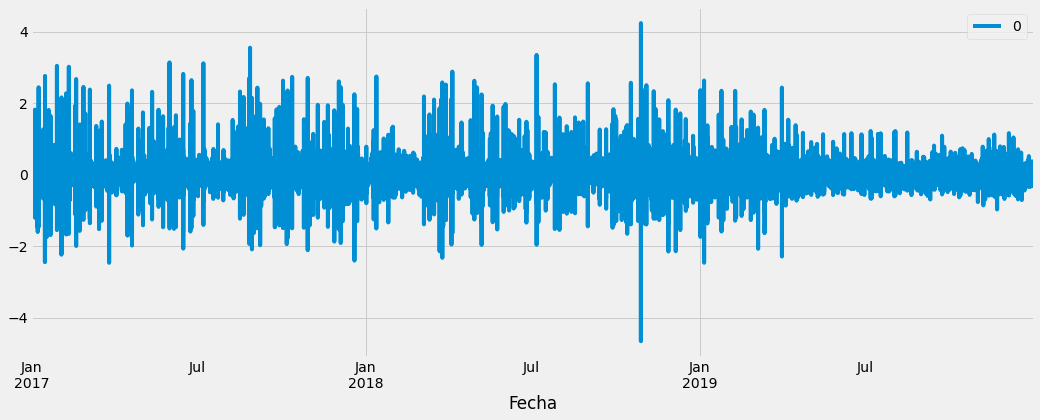

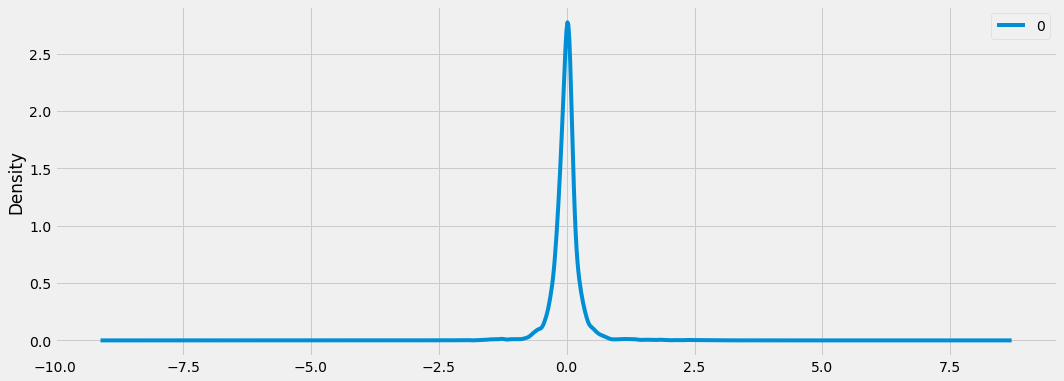

                  0
count  26279.000000
mean       0.000014
std        0.298050
min       -4.660923
25%       -0.106742
50%        0.003339
75%        0.093028
max        4.246022


In [171]:
# plot residual errors
residuals = pandas.DataFrame(results.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

In [172]:
results.plot_diagnostics()
pyplot.show()

AttributeError: 'ARIMAResults' object has no attribute 'plot_diagnostics'

Let's analyze the plots above:
- **Top Left:** The residual error fluctuate around a mean of zero but seems to have a deacreasing trend
- **Top Right:** The density plot doesn't suggest a normal distribution, it seems to be skewed
- **Bottom Left:** Distribution skewed confirmed, otherwise the dots would fall perfectly in line with the red line
- **Bottom Righ:** It shows some autocorrelation

Due to the skewed data, we will have to apply some transformation to it in order to make it stationary

## Validating forecast
We will produce a forecast of a small period in order to validate it and apply the forecast in larger predictions

In [ ]:
X = arima_dataset.Emisiones
forecast_points = [0.7, 0.8, 0.9]
sizes = [int(len(X) * point) for point in forecast_points]

train, test = [X[0:size], X[size:len(X)] for size in sizes]

histories = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()

predicted=15.158414, expected=15.231867
predicted=15.185340, expected=15.247023
predicted=15.202094, expected=15.165219
predicted=15.131087, expected=15.180807
predicted=15.147417, expected=14.966769
predicted=14.956106, expected=14.841571
predicted=14.843617, expected=14.769282
predicted=14.778124, expected=14.815722
predicted=14.819525, expected=14.888245
predicted=14.884834, expected=15.080577
predicted=15.058926, expected=15.227588
predicted=15.193244, expected=15.285723
predicted=15.248051, expected=15.260184
predicted=15.227434, expected=14.994007
predicted=14.988953, expected=14.604862
predicted=14.637481, expected=14.054811
predicted=14.138008, expected=13.455207
predicted=13.590240, expected=13.072186
predicted=13.234802, expected=12.935281
predicted=13.100208, expected=12.844939
predicted=13.007617, expected=12.929342
predicted=13.073339, expected=13.449487
predicted=13.534550, expected=14.105935
predicted=14.122792, expected=14.626841
predicted=14.592870, expected=14.761496
